In [1]:
import pandahouse as ph
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
cmap=sns.cubehelix_palette(as_cmap=True)
sns.set(font_scale=2, 
    style="whitegrid",
    rc={'figure.figsize':(12,8)})  

In [3]:
# подключение к базе default
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [5]:
q = '''
    SELECT 
        count() 
    FROM 
        {db}.ldn_listings 
    LIMIT 10
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


В датасете, содержащем информацию об объявлениях на Airbnb в Лондоне 85207 строк.
- Необходимо выгрузить следующие данные:  
price - ценa за ночь,  
room_type - тип комнаты,  
review_scores_rating - рейтинг жилья.  
- Отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

In [15]:
query_available = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating,
        id
    FROM 
        {db}.ldn_listings 
    WHERE review_scores_rating IS NOT NULL
    GROUP BY room_type, price, review_scores_rating, id
    ORDER BY id
    LIMIT 1000
    '''

df = ph.read_clickhouse(query=query_available, connection=connection_default)
df

,room_type,price,review_scores_rating,id
0,Private room,65.0,97.0,13913
1,Entire home/apt,100.0,96.0,15400
2,Entire home/apt,300.0,94.0,17402
3,Entire home/apt,65.0,93.0,25023
4,Private room,29.0,96.0,25123
...,...,...,...,...
995,Entire home/apt,165.0,100.0,616278
996,Private room,99.0,93.0,617678
997,Private room,45.0,100.0,618082
998,Private room,20.0,88.0,619010


- Построим график рассеивания зависимости средней оценки от средней цены по типу жилья

In [16]:
df.groupby('room_type').agg('price').quantile(q=0.75)

room_type
Entire home/apt    152.0
Hotel room         157.0
Private room        60.0
Shared room         21.5
Name: price, dtype: float64

In [27]:
plot1 = df.groupby('room_type').agg({'price': 'mean', 'review_scores_rating': 'mean'}).reset_index()

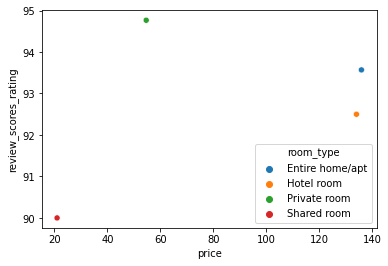

In [28]:
sns.scatterplot(data=plot1, x="price", y="review_scores_rating", hue="room_type")

In [30]:
plot1

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


Помимо аренды жилья, на Airbnb также есть мероприятия, которые организуют местные жители - experiences_offered. 

- Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). 

In [52]:
query_experiences = '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    '''

df_exp = ph.read_clickhouse(query=query_experiences, connection=connection_default)
df_exp

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [53]:
df_exp['host_verifications'] = df_exp['host_verifications'].apply(lambda x: x.strip("[]").split(','))

In [54]:
df_exp['host_verifications'].explode().value_counts()

'email'                     1345
 'phone'                    1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
 'manual_online'              16
'phone'                       16
 'sent_id'                     6
Name: host_verifications, dtype: int64

Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.

- Визуализируем результат с помощью heatmap

In [78]:
query_impression = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        count() AS experiences_count
    FROM 
        {db}.ldn_listings
    GROUP BY neighbourhood_cleansed, experiences_offered
    HAVING experiences_offered != 'none'
    ORDER BY experiences_count DESC
    LIMIT 100
      '''

df_imp = ph.read_clickhouse(query=query_impression, connection=connection_default)
df_imp

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [66]:
plot2 = df_imp.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

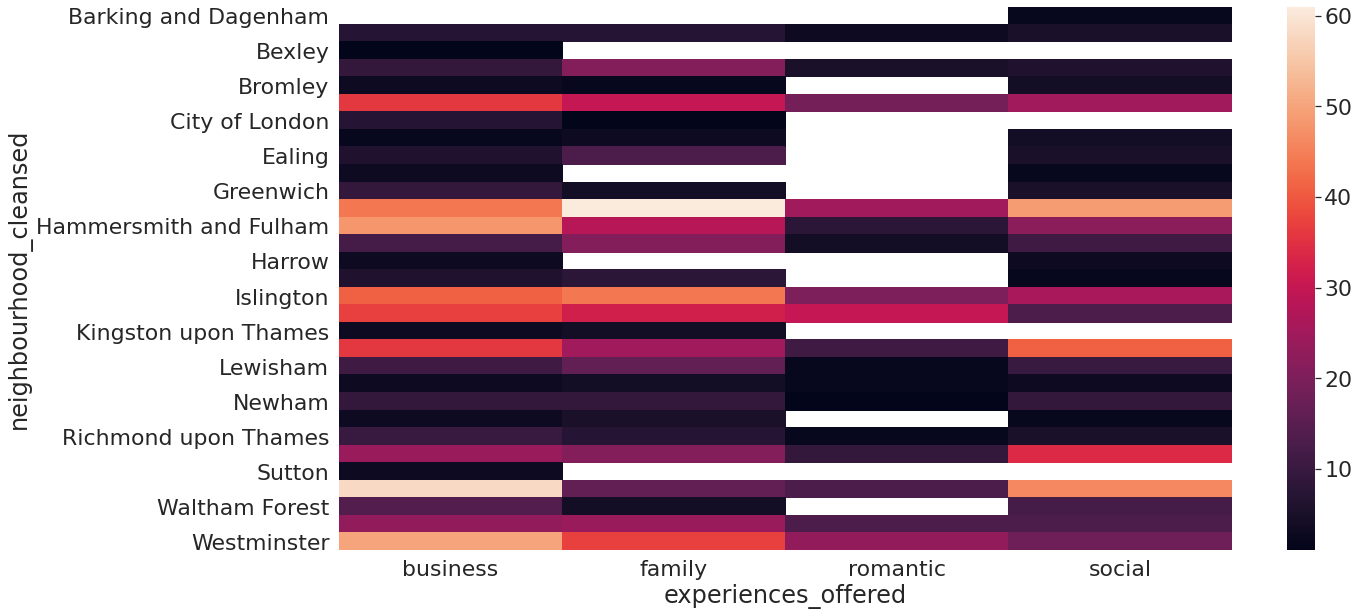

In [75]:
sns.heatmap(plot2)

Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 

Далее построим графики: на первом - исходные данные распределения цен для каждого типа жилья, на втором – логарифмированные значения (np.log())

In [6]:
query_apartments = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'

      '''

df_apart = ph.read_clickhouse(query=query_apartments, connection=connection_default)
df_apart

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


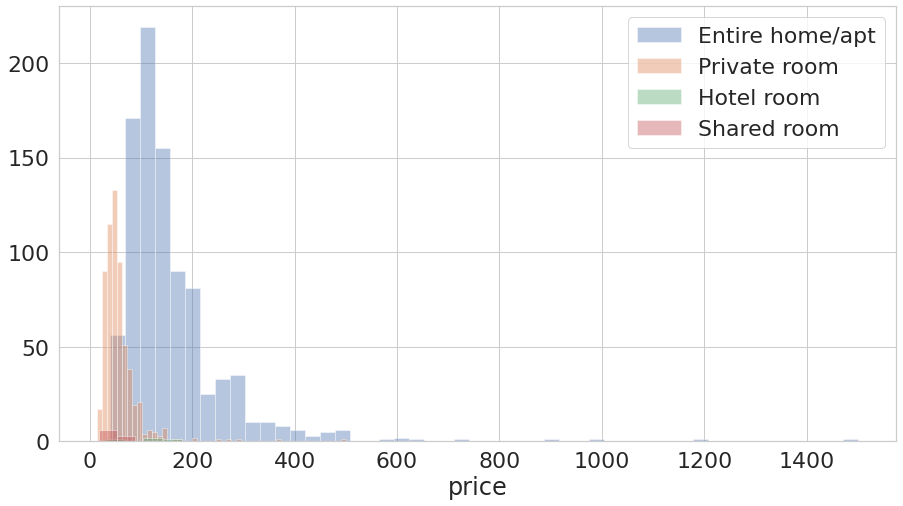

In [12]:
sns.distplot(df_apart.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_apart.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_apart.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_apart.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

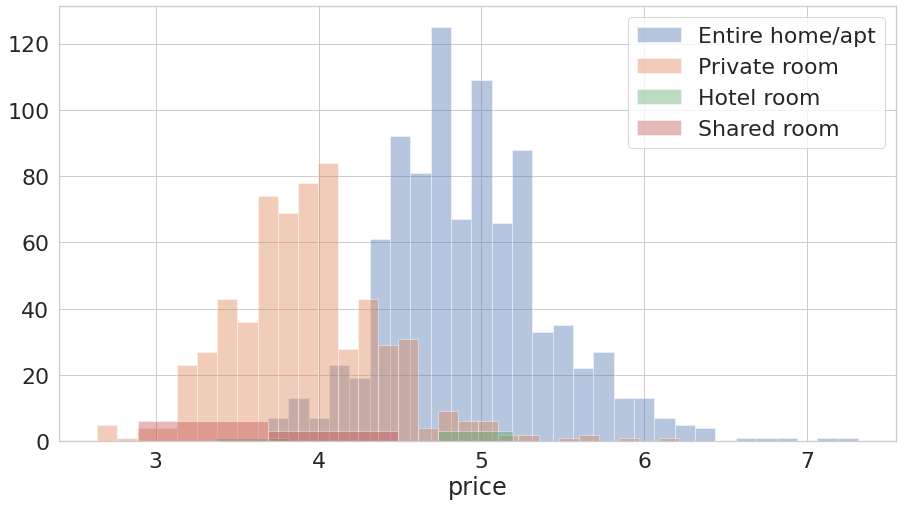

In [13]:
sns.distplot(np.log(df_apart.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_apart.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_apart.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_apart.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

Далее выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. 

Построим график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). 

In [33]:
query_prices = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review
    FROM 
        {db}.ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
      '''

df_prices = ph.read_clickhouse(query=query_prices, connection=connection_default)
df_prices

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [34]:
df_prices['first_review'] = df_prices['first_review'].apply(lambda x: x[0:4])

In [41]:
df_prices = df_prices.sort_values('first_review')

In [42]:
df_prices

,room_type,price,first_review
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


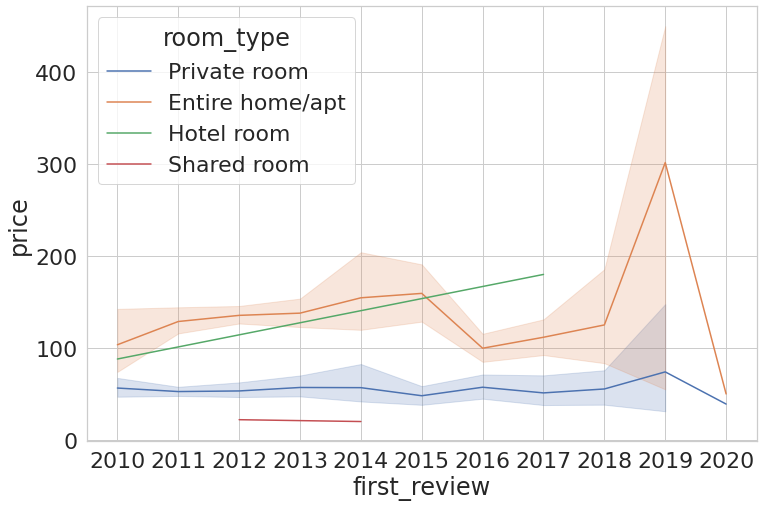

In [43]:
sns.lineplot(x='first_review',y='price',hue='room_type',data=df_prices)